In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-04 02:14:27.672251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 02:14:27.677868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 02:14:27.678256: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-04 02:14:27.943675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 02:14:27.944436: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 02:14:27.944781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-04 02:14:27.945061: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.00000000e+00, 0.00000000e+00, 2.48697042e+00],
         [1.34084284e+00, 0.00000000e+00, 9.57636714e-01],
         [0.00000000e+00, 0.00000000e+00, 1.81456089e+00],
         ...,
         [0.00000000e+00, 1.88611972e+00, 9.30403352e-01],
         [5.63635445e+00, 0.00000000e+00, 8.32903624e-01],
         [1.25397786e-01, 3.81343633e-01, 0.00000000e+00]],

        [[3.67994714e+00, 0.00000000e+00, 1.53381169e+00],
         [0.00000000e+00, 1.35904586e+00, 3.05112267e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [1.37805092e+00, 0.00000000e+00, 0.00000000e+00],
         [4.64466065e-01, 1.85873711e+00, 3.54450035e+00],
         [4.07128716e+00, 0.00000000e+00, 0.00000000e+00]],

        [[1.58405364e+00, 1.55126536e+00, 0.00000000e+00],
         [7.42142916e-01, 0.00000000e+00, 2.61248112e+00],
         [0.00000000e+00, 0.00000000e+00, 1.66215765e+00],
         ...,
         [0

In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.00000000e+00, 0.00000000e+00, 2.48697042e+00],
          [1.34084284e+00, 0.00000000e+00, 9.57636714e-01],
          [0.00000000e+00, 0.00000000e+00, 1.81456089e+00],
          ...,
          [0.00000000e+00, 1.88611972e+00, 9.30403352e-01],
          [5.63635445e+00, 0.00000000e+00, 8.32903624e-01],
          [1.25397786e-01, 3.81343633e-01, 0.00000000e+00]],
 
         [[3.67994714e+00, 0.00000000e+00, 1.53381169e+00],
          [0.00000000e+00, 1.35904586e+00, 3.05112267e+00],
          [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
          ...,
          [1.37805092e+00, 0.00000000e+00, 0.00000000e+00],
          [4.64466065e-01, 1.85873711e+00, 3.54450035e+00],
          [4.07128716e+00, 0.00000000e+00, 0.00000000e+00]],
 
         [[1.58405364e+00, 1.55126536e+00, 0.00000000e+00],
          [7.42142916e-01, 0.00000000e+00, 2.61248112e+00],
          [0.00000000e+00, 0.00000000e+00, 1.66215765e+0

<IPython.core.display.Javascript object>


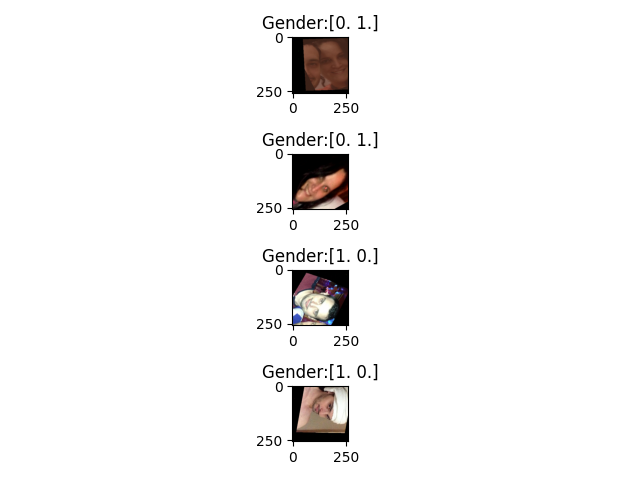

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(256, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(64, 3, strides=(2,2), padding='same', activation='relu', name='enc_conv5'),
        tf.keras.layers.Flatten(name="enc_flat"),
        tf.keras.layers.Dense(latentSize, name="enc_out")
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latentSize), name='dec_inp'),
        tf.keras.layers.Dense(8*8*64, activation='relu', name='dec_fc1'),
        tf.keras.layers.Reshape(target_shape=(8,8,64), name='dec_reshape'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(256, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(128, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(64, 3, strides=(2,2), padding='same', activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 3, strides=(2,2), padding='same', activation='tanh', name='dec_deconv5')
    ], name='dec')

    fc1 = tf.keras.layers.Dense(256, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    o = fc1(latent)
    o = do1(o)
    
    outLab = fc2(o)
    
    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_12')
    
    #encoder.summary()
    #decoder.summary()
    
    return model

In [33]:
LATENT_SIZE = 64

In [34]:
model = createModel(LATENT_SIZE)

In [35]:
model.summary()

Model: "AE_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 64)           1739392     ['tf.math.subtract[0][0]']   

### Compile Model

In [36]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [37]:
def schedule(epoch, lr):
    return lr

In [38]:
logBasePath = "log/AE_12"
logPrefix = "log"

In [39]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel(LATENT_SIZE)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    lossWeight = {"gender": 2500, "recon": 1}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, loss_weights=lossWeight, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-04 02:14:50.641039: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-04 02:14:50.641063: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-04 02:14:50.641083: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-04 02:14:50.746513: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-04 02:14:50.747872: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-04 02:14:51.391559: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  12/3528 [..............................] - ETA: 16s - loss: 7162.0845 - gender_out_loss: 0.6916 - tf.math.multiply_1_loss: 5433.1084 - gender_out_accuracy: 0.5625    

2022-11-04 02:14:52.180960: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 16s 4ms/step - loss: 7724.5894 - gender_out_loss: 0.6935 - tf.math.multiply_1_loss: 5990.7661 - gender_out_accuracy: 0.4745
Epoch 1/300
   1/1000 [..............................] - ETA: 16:22 - loss: 7639.3652 - gender_out_loss: 0.6928 - tf.math.multiply_1_loss: 5907.3179 - gender_out_accuracy: 0.5000

2022-11-04 02:15:07.903641: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-04 02:15:07.903661: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


  16/1000 [..............................] - ETA: 41s - loss: 8716.7363 - gender_out_loss: 0.6883 - tf.math.multiply_1_loss: 6995.9907 - gender_out_accuracy: 0.5781 

2022-11-04 02:15:08.339481: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-04 02:15:08.340161: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-04 02:15:08.367870: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 3098 callback api events and 3057 activity events. 
2022-11-04 02:15:08.390540: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-04 02:15:08.413327: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_12/log_0/plugins/profile/2022_11_04_02_15_08

2022-11-04 02:15:08.444773: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_12/log_0/plugins/profile/2022_11_04_02_15_08/rachanon-pc1.trace.json.gz
2022-11-04 02:15:08.476247: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log

1000/1000 [==============================] - 25s 24ms/step - loss: 4578.0972 - gender_out_loss: 0.6859 - tf.math.multiply_1_loss: 2863.4268 - gender_out_accuracy: 0.5717 - val_loss: 3861.3884 - val_gender_out_loss: 0.6868 - val_tf.math.multiply_1_loss: 2144.4360 - val_gender_out_accuracy: 0.5601
Epoch 2/300
1000/1000 [==============================] - 23s 23ms/step - loss: 3317.3132 - gender_out_loss: 0.6629 - tf.math.multiply_1_loss: 1659.9702 - gender_out_accuracy: 0.6095 - val_loss: 3411.3066 - val_gender_out_loss: 0.6841 - val_tf.math.multiply_1_loss: 1700.9506 - val_gender_out_accuracy: 0.5511
Epoch 3/300
1000/1000 [==============================] - 23s 23ms/step - loss: 3024.1765 - gender_out_loss: 0.6498 - tf.math.multiply_1_loss: 1399.7681 - gender_out_accuracy: 0.6025 - val_loss: 3248.7832 - val_gender_out_loss: 0.6861 - val_tf.math.multiply_1_loss: 1533.6262 - val_gender_out_accuracy: 0.5519
Epoch 4/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2982.6

1000/1000 [==============================] - 23s 23ms/step - loss: 2418.1035 - gender_out_loss: 0.6332 - tf.math.multiply_1_loss: 835.0244 - gender_out_accuracy: 0.6410 - val_loss: 2699.4106 - val_gender_out_loss: 0.6798 - val_tf.math.multiply_1_loss: 999.9827 - val_gender_out_accuracy: 0.5890
Epoch 54/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2322.4270 - gender_out_loss: 0.6121 - tf.math.multiply_1_loss: 792.1417 - gender_out_accuracy: 0.6690 - val_loss: 2714.2354 - val_gender_out_loss: 0.6659 - val_tf.math.multiply_1_loss: 1049.5685 - val_gender_out_accuracy: 0.6183
Epoch 55/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2373.0393 - gender_out_loss: 0.6185 - tf.math.multiply_1_loss: 826.7858 - gender_out_accuracy: 0.6543 - val_loss: 2565.0430 - val_gender_out_loss: 0.6308 - val_tf.math.multiply_1_loss: 988.1652 - val_gender_out_accuracy: 0.6469
Epoch 56/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2323.734

Epoch 80/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2192.9387 - gender_out_loss: 0.5705 - tf.math.multiply_1_loss: 766.6023 - gender_out_accuracy: 0.6960 - val_loss: 2767.1240 - val_gender_out_loss: 0.7187 - val_tf.math.multiply_1_loss: 970.3041 - val_gender_out_accuracy: 0.6130
Epoch 81/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2342.5769 - gender_out_loss: 0.6103 - tf.math.multiply_1_loss: 816.7912 - gender_out_accuracy: 0.6683 - val_loss: 2530.2788 - val_gender_out_loss: 0.6282 - val_tf.math.multiply_1_loss: 959.6693 - val_gender_out_accuracy: 0.6377
Epoch 82/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2290.4915 - gender_out_loss: 0.5974 - tf.math.multiply_1_loss: 796.9158 - gender_out_accuracy: 0.6852 - val_loss: 2472.6990 - val_gender_out_loss: 0.6024 - val_tf.math.multiply_1_loss: 966.7432 - val_gender_out_accuracy: 0.6754
Epoch 83/300
1000/1000 [==============================] - 23s 23ms/step - lo

Epoch 107/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2131.3757 - gender_out_loss: 0.5445 - tf.math.multiply_1_loss: 770.2176 - gender_out_accuracy: 0.7203 - val_loss: 2538.7791 - val_gender_out_loss: 0.6284 - val_tf.math.multiply_1_loss: 967.6899 - val_gender_out_accuracy: 0.6658
Epoch 108/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2231.0771 - gender_out_loss: 0.5806 - tf.math.multiply_1_loss: 779.6314 - gender_out_accuracy: 0.6925 - val_loss: 2394.0278 - val_gender_out_loss: 0.5781 - val_tf.math.multiply_1_loss: 948.8244 - val_gender_out_accuracy: 0.6887
Epoch 109/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2185.9143 - gender_out_loss: 0.5584 - tf.math.multiply_1_loss: 790.0030 - gender_out_accuracy: 0.6998 - val_loss: 2522.5691 - val_gender_out_loss: 0.6257 - val_tf.math.multiply_1_loss: 958.2816 - val_gender_out_accuracy: 0.6464
Epoch 110/300
1000/1000 [==============================] - 23s 23ms/step 

1000/1000 [==============================] - 23s 23ms/step - loss: 2094.8464 - gender_out_loss: 0.5331 - tf.math.multiply_1_loss: 762.1575 - gender_out_accuracy: 0.7337 - val_loss: 2328.5747 - val_gender_out_loss: 0.5512 - val_tf.math.multiply_1_loss: 950.4882 - val_gender_out_accuracy: 0.7215
Epoch 160/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2004.9999 - gender_out_loss: 0.4972 - tf.math.multiply_1_loss: 761.9507 - gender_out_accuracy: 0.7573 - val_loss: 2710.2444 - val_gender_out_loss: 0.7050 - val_tf.math.multiply_1_loss: 947.6194 - val_gender_out_accuracy: 0.6478
Epoch 161/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2053.0645 - gender_out_loss: 0.5248 - tf.math.multiply_1_loss: 741.1454 - gender_out_accuracy: 0.7297 - val_loss: 2832.4207 - val_gender_out_loss: 0.7590 - val_tf.math.multiply_1_loss: 934.9179 - val_gender_out_accuracy: 0.6249
Epoch 162/300
1000/1000 [==============================] - 23s 23ms/step - loss: 2103.5

1000/1000 [==============================] - 23s 23ms/step - loss: 1926.8130 - gender_out_loss: 0.4705 - tf.math.multiply_1_loss: 750.4752 - gender_out_accuracy: 0.7710 - val_loss: 2118.5100 - val_gender_out_loss: 0.4717 - val_tf.math.multiply_1_loss: 939.1611 - val_gender_out_accuracy: 0.7666
Epoch 212/300
1000/1000 [==============================] - 23s 23ms/step - loss: 1920.5627 - gender_out_loss: 0.4616 - tf.math.multiply_1_loss: 766.4600 - gender_out_accuracy: 0.7772 - val_loss: 2535.6355 - val_gender_out_loss: 0.6327 - val_tf.math.multiply_1_loss: 953.8462 - val_gender_out_accuracy: 0.6954
Epoch 213/300
1000/1000 [==============================] - 23s 23ms/step - loss: 1847.4226 - gender_out_loss: 0.4375 - tf.math.multiply_1_loss: 753.5479 - gender_out_accuracy: 0.7983 - val_loss: 2243.2593 - val_gender_out_loss: 0.5225 - val_tf.math.multiply_1_loss: 937.1255 - val_gender_out_accuracy: 0.7438
Epoch 214/300
1000/1000 [==============================] - 23s 23ms/step - loss: 1855.9

1000/1000 [==============================] - 23s 23ms/step - loss: 1737.2853 - gender_out_loss: 0.3896 - tf.math.multiply_1_loss: 763.2737 - gender_out_accuracy: 0.8207 - val_loss: 2079.8230 - val_gender_out_loss: 0.4546 - val_tf.math.multiply_1_loss: 943.3366 - val_gender_out_accuracy: 0.7770
Epoch 264/300
1000/1000 [==============================] - 23s 23ms/step - loss: 1788.5850 - gender_out_loss: 0.4129 - tf.math.multiply_1_loss: 756.3032 - gender_out_accuracy: 0.8073 - val_loss: 1996.0264 - val_gender_out_loss: 0.4199 - val_tf.math.multiply_1_loss: 946.2305 - val_gender_out_accuracy: 0.8013
Epoch 265/300
1000/1000 [==============================] - 23s 23ms/step - loss: 1788.6871 - gender_out_loss: 0.4030 - tf.math.multiply_1_loss: 781.3053 - gender_out_accuracy: 0.8215 - val_loss: 2154.6560 - val_gender_out_loss: 0.4871 - val_tf.math.multiply_1_loss: 936.8458 - val_gender_out_accuracy: 0.7578
Epoch 266/300
1000/1000 [==============================] - 23s 23ms/step - loss: 1743.8

In [40]:
out = model(x)

In [41]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[3.32907736e-01, 3.17039788e-01, 1.90901756e-01],
          [8.23415816e-02, 8.11484456e-02, 1.72852725e-01],
          [1.18728429e-01, 9.82247293e-02, 1.22452229e-01],
          ...,
          [1.10652113e+01, 7.82760286e+00, 7.13605499e+00],
          [9.63754463e+00, 6.89759493e+00, 7.03229809e+00],
          [8.50841236e+00, 6.29911947e+00, 5.92933083e+00]],
 
         [[5.27867675e-02, 2.68873572e-02, 3.85147333e-02],
          [6.61316514e-02, 4.38420475e-02, 2.96612084e-02],
          [7.67178833e-02, 3.39017808e-02, 2.32699513e-02],
          ...,
          [1.24153776e+01, 8.66961479e+00, 6.81745720e+00],
          [1.04669561e+01, 6.91841030e+00, 6.70559883e+00],
          [8.55207157e+00, 6.26973963e+00, 5.87998676e+00]],
 
         [[1.37203038e-01, 3.49429250e-02, 7.35336542e-02],
          [8.57765973e-02, 5.01801074e-02, 4.05514240e-02],
          [1.05292350e-01, 6.51133060e-02, 3.87275219e-0

<IPython.core.display.Javascript object>


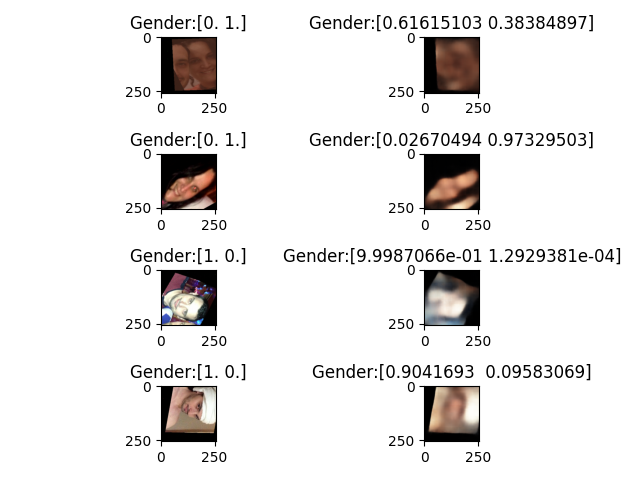

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()

In [43]:
for xTest, yTest in folds[0][1].take(1):
    pass

In [44]:
outTest = model(xTest)

In [45]:
outTest

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[4.34901863e-01, 3.95057201e-01, 2.39311159e-01],
          [1.05854720e-01, 9.83463228e-02, 2.21246928e-01],
          [1.92672461e-01, 1.77784860e-01, 1.88051909e-01],
          ...,
          [7.22873211e-02, 6.54628873e-02, 8.70001316e-02],
          [2.78449059e-02, 5.01725078e-02, 8.19160044e-02],
          [4.55139577e-02, 6.22102618e-02, 4.74518538e-02]],
 
         [[7.64670968e-02, 4.02246416e-02, 5.39115071e-02],
          [8.75928998e-02, 5.60925901e-02, 3.85451317e-02],
          [1.27247572e-01, 6.67168200e-02, 4.26869094e-02],
          ...,
          [1.65610313e-01, 1.70785636e-01, 2.36400515e-01],
          [4.93061543e-02, 5.79696894e-02, 6.90422952e-02],
          [4.10529971e-02, 7.09573925e-02, 6.71651959e-02]],
 
         [[1.93622410e-01, 4.91313636e-02, 1.07139051e-01],
          [1.31206959e-01, 6.80619478e-02, 5.73237240e-02],
          [1.57463551e-01, 1.11014843e-01, 6.67700171e-0

<IPython.core.display.Javascript object>


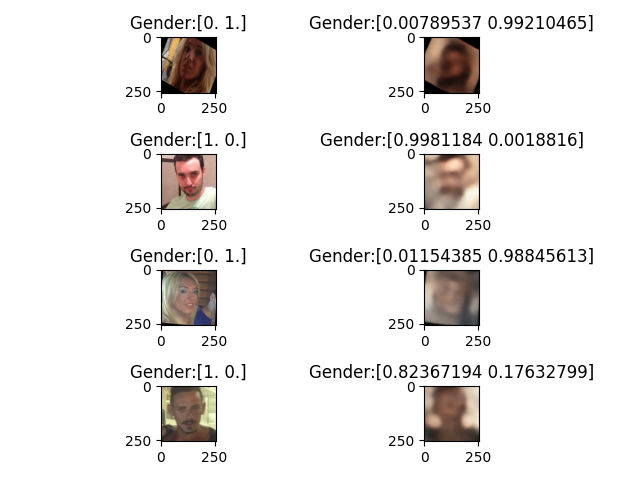

In [46]:
fig3, ax3 = plt.subplots(nrows=VAL_BATCH_SIZE, ncols=2)

if(VAL_BATCH_SIZE is None or VAL_BATCH_SIZE == 1):
    ax3[0].imshow(x/255)
    ax3[0].set_title(yTest['gender'])
    
    ax3[1].imshow(out['recon']/255)
    ax3[1].set_title(outTest['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax3[i, 0].imshow(xTest[i]/255)
        ax3[i, 0].set_title(f"Gender:{yTest['gender'][i]}")
        
        ax3[i, 1].imshow(outTest['recon'][i]/255)
        ax3[i, 1].set_title(f"Gender:{outTest['gender'][i]}")
        
plt.tight_layout()